C:\Users\kali\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0.9750464569148679
[1101.49755273 1072.15297561 1018.67033619 1060.59788637 1072.83703869
 1073.05284451 1091.63019371 1111.00382672 1114.03988384 1121.96459337
 1131.10584813 1128.87860712 1148.44082173 1164.07827784 1135.57051913
 1121.79749542 1087.43504295 1102.70360645 1113.68755237 1120.94812941
 1134.60019515 1149.39791341 1180.86538825 1185.29958329 1156.98305498
 1168.19261068 1170.00725981 1152.85832314 1118.27952038 1114.72423323
 1112.29536224 1069.53872282 1041.48730108 1072.78019624 1020.28453165] 0.9750464569148679


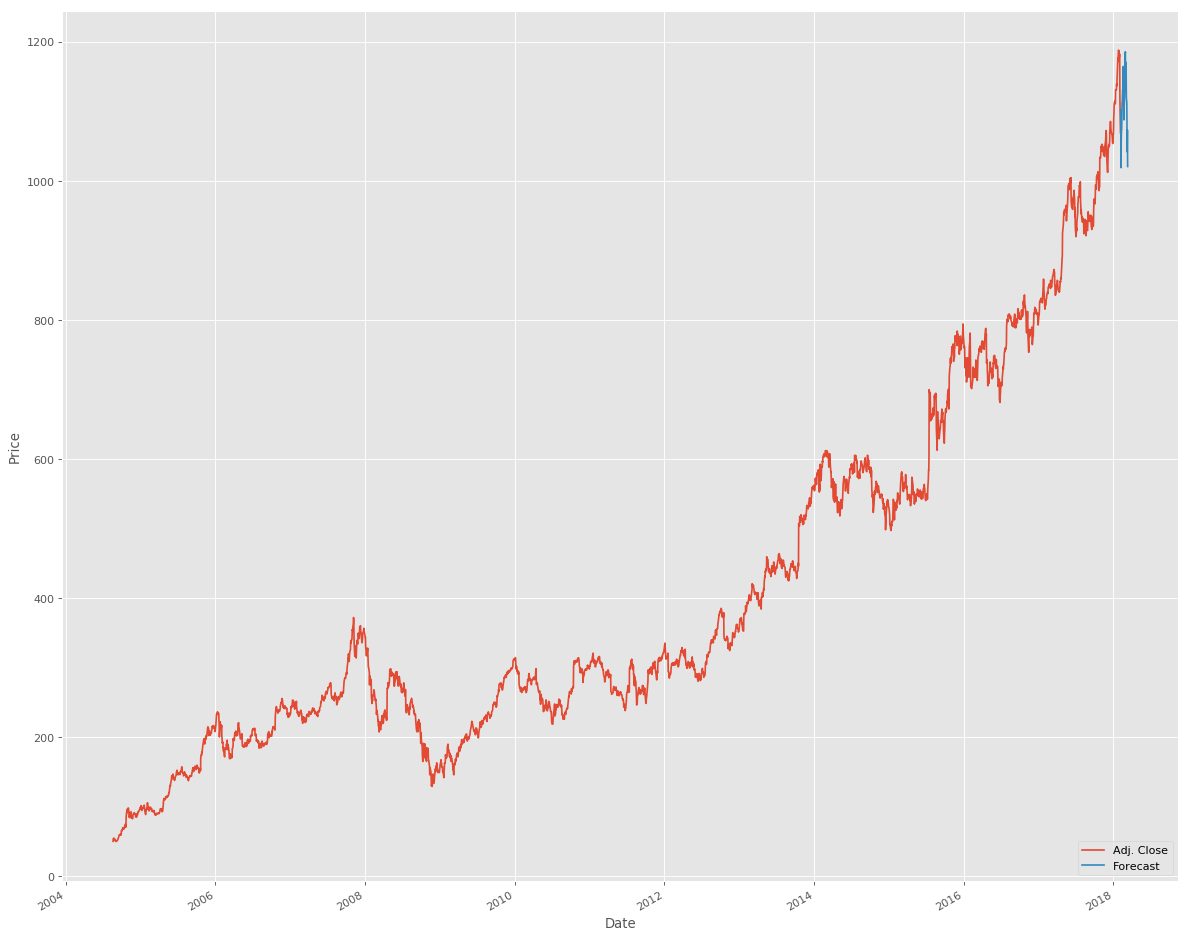

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import math ,datetime
from sklearn import preprocessing, cross_validation , svm
from sklearn.linear_model import LinearRegression

import quandl

import matplotlib.pyplot as plt
from matplotlib import style  
style.use('ggplot') 
# cant use indent as a formating device... i hate python


df = quandl.get('WIKI/GOOGL')
df = df[['Adj. Open','Adj. High','Adj. Low','Adj. Close','Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

df = df[['Adj. Close','HL_PCT','PCT_change','Adj. Volume']]
forecast_col = 'Adj. Close'
df.fillna(-99999, inplace=True)
forecast_out = int(math.ceil(0.01*len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)

#

x = np.array(df.drop(['label'],1))
x = preprocessing.scale(x)
x_lately = x[-forecast_out:]
x = x[:-forecast_out]

df.dropna(inplace=True)
y = np.array(df['label'])

x_train, x_test, y_train, y_test = cross_validation.train_test_split (x , y, test_size=0.2)
clf = LinearRegression(n_jobs=-1) #multithreading 
clf.fit(x_train, y_train)
accuracy = clf.score(x_test,y_test)   
forecast_set = clf.predict(x_lately)

print(accuracy)
print(forecast_set, accuracy)

df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]

    
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')  
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()




In [2]:
clf = svm.SVR()
clf.fit(x_train, y_train)
accuracy = clf.score(x_test,y_test)   
print(accuracy)

0.8019068496938216


In [3]:
clf = svm.SVR(kernel='linear')
clf.fit(x_train, y_train)
accuracy = clf.score(x_test,y_test)   
print(accuracy)

0.9735141142389838


In [4]:
clf = svm.SVR(kernel='poly')
clf.fit(x_train, y_train)
x_plot= clf.predict(x_test)
accuracy = clf.score(x_test,y_test)   
print(accuracy)

0.6011969116286389


## OK now to try some stuff on my own.... 

### Holt linear


In [5]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from pandas import Series


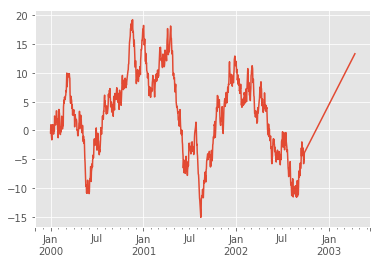

In [6]:
temp = np.random.randn(1000)
ts = Series(temp, index=pd.date_range('1/1/2000', periods=1000))
ts = ts.cumsum()

fit1 = Holt(ts).fit(smoothing_level = 0.3,smoothing_slope = 0.1)#smoothing_level = 0.3,smoothing_slope = 0.1
#forecast = fit1.forecast(200)
predict= fit1.predict(start=1001,end=1200)

#print((predict))


np_ar1 = np.array(ts)
np_ar2 = np.array(predict)
df1 = pd.DataFrame({'ar1':np_ar1})
df2 = pd.DataFrame({'ar2':np_ar2})
qq = pd.concat([df1.ar1, df2.ar2], axis=0)
#temp = np.concatenate(temp,qqq, axis=None)

#print(np_ar2)

ts = Series(np.asarray(qq), index=pd.date_range('1/1/2000', periods=1200))
#print(ts)

ts.plot()




### holtwinters ExponentialSmoothing

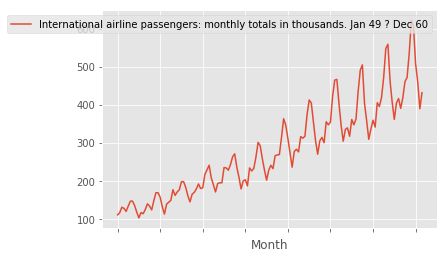

In [7]:
# https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line
# https://stackoverflow.com/questions/50785479/holt-winters-time-series-forecasting-with-statsmodels


from statsmodels.tsa.holtwinters import ExponentialSmoothing

df = pd.read_csv('C:/Users/kali/Documents/Notebooks/Time_Series_Prediction/international-airline-passengers.csv', 
                 parse_dates=['Month'], 
                 index_col='Month'
)
df.plot.line()

C:\Users\kali\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


[343.11984637306654, 374.5367860770397, 394.2171841045, 370.3074119313054, 432.43633422614454, 417.3240094419237, 436.9296994650792, 497.2580229453982, 572.3202060975087, 576.6555715200899, 468.86623033558703, 398.8433143924748, 343.11984637306654, 374.5367860770397]


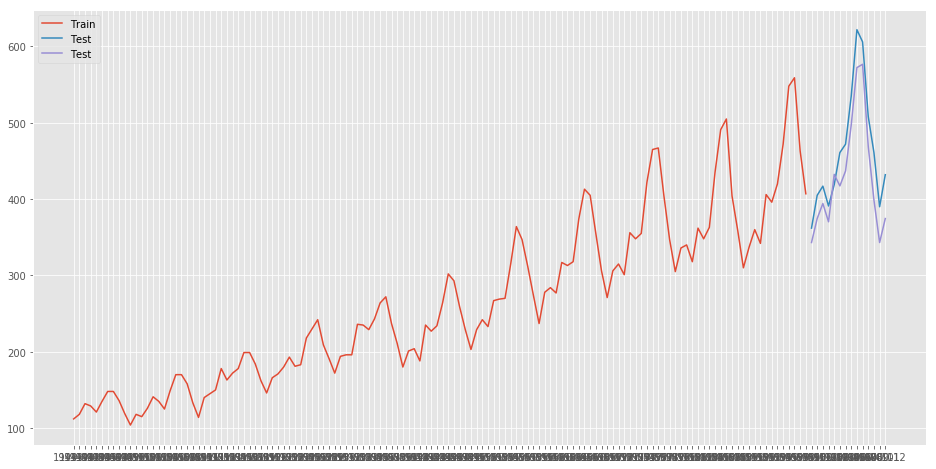

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing


train, test = df.iloc[:130, 0], df.iloc[130:, 0]
test = test.drop(test.index[len(test)-1])



train.index.freq = 'MS'
test.index.freq = 'MS'


#train.index = pd.DatetimeIndex(train.index.values,                               freq='MS')
model = ExponentialSmoothing(train, seasonal='mul', seasonal_periods=12).fit()
pred = model.predict(start=test.index[0], end=test.index[-1])

pred.index.freq = 'MS'


list = []
for i in range(len(pred)):
    list.append(pred[i])
    
    
    
print(list)

plt.figure(figsize=(16,8))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, pred, label='Test')
#plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best')



### ARIMA

ref: [1, for prams](https://stackoverflow.com/questions/44235558/statespace-sarimax-model-why-the-model-use-all-the-data-to-train-mode-and-pred)

[2, docs](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.fit.html#statsmodels.tsa.statespace.sarimax.SARIMAX.fit)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line
df = pd.read_csv('C:/Users/kali/Documents/Notebooks/Time_Series_Prediction/international-airline-passengers.csv', 
                 parse_dates=['Month'], 
                 index_col='Month'
)
df.plot.line()

In [ ]:
y_hat_avg = [0]

train, test = df.iloc[:130, 0], df.iloc[130:, 0]
test = test.drop(test.index[len(test)-1])



train.index.freq = 'MS'
test.index.freq = 'MS'
pred.index.freq = 'MS'


model = SARIMAX(train,order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit() #order=(2, 1, 4),seasonal_order=(0,1,1,7)

pred = model.predict(start=test.index[0], end=test.index[-1])#dynamic=True



list = []
for i in range(len(pred)):
    list.append(pred[i])
    
    
    
#print(list)



plt.figure(figsize=(16,8))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, list, label='SARIMAX')
plt.legend(loc='best')

error = mean_squared_error(test, pred)
print("mean_squared_error: ",error)


In [12]:
#plt.figure(figsize=(16,8))
#plt.plot(ts, label="ts")
#plt.plot(np_ar2, label="holt")
#plt.legend(loc='best')
#plt.show()